<a href="https://colab.research.google.com/github/maxkleiner/maXbox/blob/master/waterpumpspredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Preprocessor and Classifier for Water Pumps State, modified for Kaggle Competition by Max.
# https://towardsdatascience.com/water-pumps-maintenance-prediction-data-science-illustrated-20c7100017c5
# Licensed under the Apache License, Version 2.0 (the "License");  locs=277

import numpy as np
import pandas as pd
import random
import pdb
import math
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import sklearn.model_selection #.train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import sklearn.tree as dtreec
import sklearn.ensemble as densemble
from sklearn.model_selection import cross_validate   #Additional sklearn functions
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import scipy.stats as ss


Function Definitions:


In [24]:
def transform_feature(df, column_name):
    unique_values = set(df[column_name].tolist())
    transformer_dict = {}
    for index, value in enumerate(unique_values):
        transformer_dict[value] = index
    df[column_name] = df[column_name].apply(lambda y: transformer_dict[y])
    return df

def cramers_stat(confusion_matrix):
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))


def batch_gen(X, batch_size):
    n_batches = X.shape[0]/float(batch_size)
    n_batches = int(math.ceil(n_batches))
    end = int(X.shape[0]/float(batch_size)) * batch_size
    n = 0
    for i in range(0,n_batches):
        if i < n_batches - 1: 
            batch = X[i*batch_size:(i+1) * batch_size, :]
            yield batch
        else:
            batch = X[end: , :]
            n += X[end:, :].shape[0]
            yield batch
        

# Find columns with Null values
def find_nullvalues(dfX):
  nullcols = []
  for col in dfX.columns:
    nbnull = (dfX[col].isnull()*1).sum()
    if ( nbnull > 0 ):
        tp = type(dfX[dfX[col].notnull()][col].iat[0]) # type of first non null value
        nullcols.append([col, tp])
        print(col, nbnull, tp)

def find_defaultvalues(dfX, numerics):
  for col in numerics: # Check frequency of most common values
    cs = dfX[col].value_counts(normalize=True, sort=True, ascending=False)
    for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*1000)/10. )

def find_rarevaules(dfX, categories):
    for col in categories:
        cs = dfX[col].value_counts(normalize=False, sort=True, ascending=False)
    rare_values = [k for k in cs.keys() if cs[k]<40] # Theshold = 40 occurrences
    if len(rare_values)>0:
        print( 'Trim values : ', col, len(rare_values))
        dfX.loc[dfX[col].isin(rare_values), col] = col+'_rare'

def find_mostvalues(dfX, dates):
    for col in dates: 
    # Check frequency of most common values
      cs = dfX[col].value_counts(normalize=True, sort=True, ascending=False)
      for k in cs.keys()[0:5]:
        print( col, k, int(cs[k]*10000)/100. )
      print('')


# Search for variables that are very similar and remove "near duplicates"
def show_similars(df, cols, threshold=0.90):
    for i1, col1 in enumerate(cols):
        for i2, col2 in enumerate(cols):
            if (i1<i2):
                cm12 = pd.crosstab(df[col1], df[col2]).values # confusion matrix
                #cv12 = cramers_corrected_stat(cm12) # WARNING : cramer V is a symetric stat ?
                cv12 = cramers_stat(cm12) # compare to ?
                if (cv12 > threshold):
                    print((col1, col2), int(cv12*100))

labels=['functional','functional needs repair','non functional']
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar(shrink=0.7)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right', fontsize=12)
    plt.yticks(tick_marks, labels , fontsize=12)
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

    if __name__ == "__main__":
      X = np.random.rand(123, 32)
      for batch in batch_gen(X, 21):
        print (batch.shape)




This is an interesting dataset. The target variable consisted of three classes of water pumps: Functional, Non-function, and the ones that require repair work. This is a classic classification problem of how to accurately predict the classes. The challenge was if we can predict which pumps are functional. The dataset is decent size but requires some serious cleaning. Except for a few numerical variables, most of the features are categorical. The numeric features aren't very helpful given the number of missing values they have. However, they are important enough not to be thrown away. On the other hand, categorical variables don't have many missing values in comparison to numerical features, but almost each of them represents at least hundreds of categories.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB
None
find null values_
funder 3635 <class 'str'>
installer 3655 <class 'str'>
subvillage 371 <class 'str'>
public_meeting 3334 <class 'bool'>
scheme_management 3877 <class 'str'>
scheme_name 28166 <class 'str'>
permit 3056 <class 'bool'>
find default values_
amount_tsh 0.0 70.0
amount_tsh 500.0 5.2
amount_tsh 50.0 4.1
amount_tsh 1000.0 2.5
amount_tsh 20.0 2.4
population 0 35.9
population 1 11.8
population 200 3.2
population 150 3.1
population 250 2.8
find rare and most values_
Trim values :  waterpoint_type 1
date_recorded 2011-03-15 0.96
date_recorded 2011-03-17 0.93
date_recorded 2013-02-03 0.91
date_recorded 2011-03-14 0.87
date_recorded 2011-03-16 0.86

constr

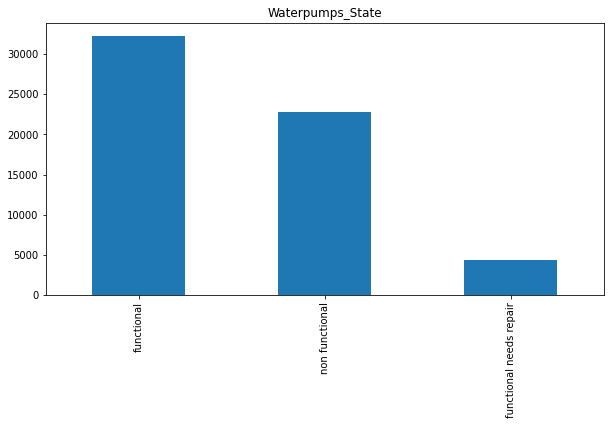

59400
status_group    59400
dtype: int64
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model Report Performance:
Accuracy : 0.7374
Train Score : 0.7635802469135803
Test Score : 0.7374158249158249
                         precision    recall  f1-score   support

             functional       0.71      0.90      0.80     12841
functional needs repair       0.52      0.15      0.24      1746
         non functional       0.81      0.62      0.70      9173

               accuracy                           0.74     23760
              macro avg       0.68      0.56      0.58     23760
           weighted avg       0.74      0.74      0.72     23760

[[11569   128  1144]
 [ 1282   266   198]
 [ 3373   114  5686]]
Confusion matrix
[[11569   128  1144]
 [ 1282   266   198]
 [ 3373   114  5686]]
(21, 32)
(21, 32)
(21, 32)
(21, 32)
(21, 32)
(18, 32)


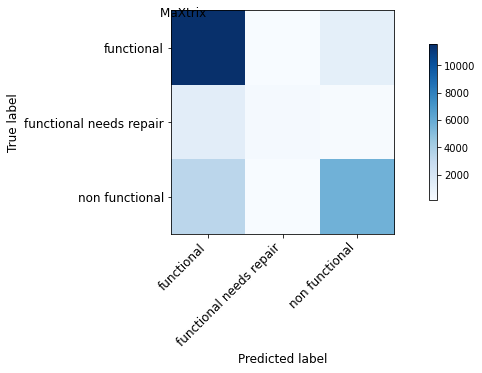

num_private 0.0
recorded_by 0.0
quality_group 0.0013805028900443236
water_quality 0.0027250851874984616
longitude 0.00413490995980675
quantity_group 0.004310736362021385
management_group 0.00440160996143544
latitude 0.004573652010186108
subvillage 0.004957786278901184
wpt_name 0.005135646733252982
id 0.005348201874962109
ward 0.006698945371065279
permit 0.006786025280208736
public_meeting 0.006786448855378314
amount_tsh 0.007146021251804273
management 0.007329513083450694
source_class 0.00739259265351751
scheme_management 0.007459712706460156
date_recorded 0.00775461337061254
extraction_type_group 0.00968029962819629
region 0.009801880702022753
source 0.010682895362053751
source_type 0.010797037329814784
gps_height 0.010984372834409142
population 0.014398317601102837
region_code 0.014614014177603194
district_code 0.016148144784015248
scheme_name 0.017383365518691678
payment_type 0.018532931710291505
construction_year 0.020973488891978108
installer 0.021012539824370704
funder 0.02143810

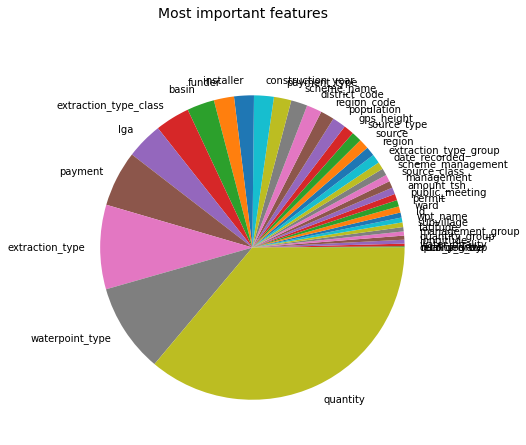

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


62.2
all classified runs to end, you know in the long run were all ...


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


' DOC\nThe group of features of (extraction_type, extraction_type_group, extraction_type_class), (payment, payment_type),\n(water_quality, quality_group), (source, source_class), (subvillage, region, region_code, district_code, lga, ward), and (waterpoint_type, waterpoint_type_group) all contain similar representation of data in different grains. Hence, we risk overfitting our data during training by including all the features in our analysis, which can be dropped.\n\n    id can be droped because it is unique for each instance.\n    num_private is ~99% zeros\nhttps://towardsdatascience.com/predicting-the-functional-status-of-pumps-in-tanzania-355c9269d0c2\n\nProject Location:\n\nhttps://github.com/ksdkalluri/identifying_faulty_pumps\n\nhttps://github.com/mzaradzki/hft-statistical-learning/blob/master/pump_it_up/pump.ipynb\n\nfrom sklearn.tree import export_graphviz\nimport graphviz\n\nexport_graphviz(tree, out_file="mytree.dot")\nwith open("mytree.dot") as f:\n    dot_graph = f.read()\

In [26]:
train_values = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv', encoding = 'iso-8859-1')
train_labels = pd.read_csv('https://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv', encoding = 'iso-8859-1')

print(train_lables.info())
train_df = train_values.merge(train_labels, on='id')

# Drop by Columns status group  from dftrain Obj in place
#train_labels = train_labels['status_group'=='functional']
# train_df.drop(train_df[train_df.status_group=='functional needs repair'].index, inplace=True)
train_values = train_df.iloc[:,0:39]
train_labels = train_df.iloc[:,40:41]

print('find null values_')
find_nullvalues(train_values)

numerics = ['amount_tsh', 'population']
geos = ['gps_height','longitude','latitude','basin','subvillage','region','region_code','district_code','lga','ward']
#dfX[geos].head(8)
dates = ['date_recorded', 'construction_year']

print('find default values_')
find_defaultvalues(train_values, numerics)
categories = [col for col in list(train_values.columns) \
                    if not(col in geos) and not(col in dates) and not (col in numerics)]
categories.remove('id')

print('find rare and most values_')
# WARNING : "construction_year" is 0 for one-third of the records
find_rarevaules(train_values, categories)
dates = ['date_recorded', 'construction_year']
find_mostvalues(train_values, dates)


print(list(train_values.columns.values))
print(train_labels.head(5))
print(train_labels.status_group.value_counts())

train_labels.status_group.value_counts().plot(title='Waterpumps_State', kind = 'bar')
# train_labels.plot(x='status_group', kind = 'bar')
plt.show()
print(train_labels.status_group.count())
print(train_labels.count())
ylabels=train_labels['status_group'].value_counts()
print(train_labels['status_group'].value_counts())
train_labels['status_encoded'] = LabelEncoder().fit_transform(train_labels['status_group'])

p = train_labels.reindex(columns=['0', '1', '2'])
#train_labels.plot.pie(y=p.item(),figsize=(5, 5), autopct='%1.1f%%', startangle=90)
#plt.show()

#print(train_values.info())

#train_df = train_values.merge(train_labels, on='id')
print(train_df.info())

#status_values = pd.factorize(train_labels['status_group'])
#print(status_values[1])
#status_valuesstr= str(['functional', 'non functional', 'functional needs repair'])
piv_df= train_df[['basin','status_group','source']]
piv_table = piv_df.pivot_table(index='basin',
                           columns='status_group', aggfunc='count')
print(piv_table)
#piv_table.plot(title='water source status', kind = 'bar')
#plt.show()

# id can be droped because it is unique for each instance.
train_values.drop('id',axis=1)
# num_private is ~99% zeros
train_values.drop('num_private',axis=1)
# : we note that "recorded_by" only has 1 value so we discard this column
train_values.drop('recorded_by', axis=1)


integer_columns = ['days_since_recorded','population','gps_height'] 
columns_to_transform = [col for col in train_values if col not in integer_columns]
for column in columns_to_transform: 
    X = transform_feature(train_values, column)
    #y = transform_feature(train_labels, column)

X_train, X_test, y_train, y_test = \
          sklearn.model_selection.train_test_split(X, train_labels, 
                                               test_size = 0.4, random_state = 0)  

                                
dtc = dtreec.DecisionTreeClassifier(criterion='gini',
                             max_depth = 10,
                             max_features = 'auto',
                             random_state = 1,
                             splitter = 'best')

rfc = sklearn.ensemble.RandomForestClassifier(n_estimators=1000, 
                                               min_samples_split=6,
                                               criterion='gini', 
                                               max_features='auto',
                                               oob_score=True,
                                               random_state=1,
                                               n_jobs=-1)

# Fit the algorithm on the data
dtc.fit(X_train, y_train['status_group'])

# Predict training set:
dtrain_predictions = dtc.predict(X_test)
dtrain_predprob = dtc.predict_proba(X_train)[:,1]

# rint model report:
target = 'status_group'
#label=y_train[target].values
label=y_test[target].values
print ("\nModel Report Performance:")
print ("Accuracy : %.4g" % accuracy_score(label, dtrain_predictions))
# print ("AUC Score (Train): %f" % roc_auc_score(label, dtrain_predprob))
print("Train Score :", dtc.score(X_train, y_train[target].values))
print("Test Score :", dtc.score(X_test, y_test[target].values))

print(classification_report(digits=2, y_true=label, y_pred=dtrain_predictions))
print(confusion_matrix(y_true=label, y_pred=dtrain_predictions))

## Constructing the Confusion Matrix
cm = confusion_matrix(label, dtrain_predictions)
np.set_printoptions(precision=2)
print('Confusion matrix')
print(cm)
plt.figure().suptitle('MaXtrix ', fontsize=12)
plot_confusion_matrix(cm)
plt.show()

names=[]
imps=[]
for name, importance in sorted(zip(X_train.columns, dtc.feature_importances_),key=lambda x: x[1]):
    #sorted(importance, key=lambda x: x[1])
    names.append(name)
    imps.append(importance)
    print(name, importance)
# Creating plot 
#print(name, importance)
fig = plt.figure(figsize =(10, 7)) 
fig.suptitle('Most important features', fontsize=14)
plt.pie(imps, labels = names)  
plt.title='most important Features'  
plt.show() 
#zipped = zip(name, importance)    
#sorted(zipped, key=lambda x: x[1])
    ## Now You Can Do Whatever You Want(plot them using a Barplot etc)

# show_similars(train_values, ['basin','region','region_code','district_code','lga'], 0.95)
#show_similars(['basin','region'], 0.95)
print('')
#show_similars(train_values, categories, 0.95)

basics = ['amount_tsh','payment',
          'population','installer','funder','source_type','quantity',
          'construction_year', 'waterpoint_type', 'extraction_type',
          'region_code','gps_height', 'lga', 'basin', 'district_code']

LR = LogisticRegression(multi_class='ovr')
LR.fit(X_train[basics].values, y_train[target].values)

score = LR.score(X_test[basics].values, y_test[target].values)
print(int(score*1000)/10)

print('all classified runs to end, you know in the long run we''re all ...')


""" DOC
The group of features of (extraction_type, extraction_type_group, extraction_type_class), (payment, payment_type),
(water_quality, quality_group), (source, source_class), (subvillage, region, region_code, district_code, lga, ward), and (waterpoint_type, waterpoint_type_group) all contain similar representation of data in different grains. Hence, we risk overfitting our data during training by including all the features in our analysis, which can be dropped.

    id can be droped because it is unique for each instance.
    num_private is ~99% zeros
https://towardsdatascience.com/predicting-the-functional-status-of-pumps-in-tanzania-355c9269d0c2

Project Location:

https://github.com/ksdkalluri/identifying_faulty_pumps

https://github.com/mzaradzki/hft-statistical-learning/blob/master/pump_it_up/pump.ipynb

from sklearn.tree import export_graphviz
import graphviz

export_graphviz(tree, out_file="mytree.dot")
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

waterpoint_type 0.051179038270807505
construction_year 0.05351109516427301
extraction_type 0.1402774970807472
quantity_group 0.14924450776263562
quantity 0.2215791028642887

  return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))
('extraction_type', 'extraction_type_group') 100
('extraction_type', 'extraction_type_class') 100
('extraction_type_group', 'extraction_type_class') 100
('management', 'management_group') 100
('payment', 'payment_type') 100
('water_quality', 'quality_group') 100
('quantity', 'quantity_group') 100
('source', 'source_type') 100
('source', 'source_class') 100
('source_type', 'source_class') 100

https://datascience.stackexchange.com/questions/28574/decisiontreeclassifier-object-has-no-attribute-importances

importance = dtc.feature_importances_
importance = pd.DataFrame(importance, index=train_values.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_ 
                            for tree in dtc.estimators_], axis=0)

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]
lables = list(train_values.columns.values)
ax = plt.bar(x, y, yerr=yerr ,align="center")
plt.xlabel('Features', fontsize = 12)
plt.ylabel('Importance', fontsize = 12)



"""    